In [1]:
import os, sys, random, json
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns

# Path setup
root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root_path not in sys.path:
    sys.path.append(root_path)

from src.video_dataset_loader import WLASLVideoDataset
from src.video_model_definition import get_model

data_root = os.path.join(root_path, "data", "video")
metadata_file = os.path.join(data_root, "WLASL_v0.3_updated.json")

# Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Using device: {device}")


[INFO] Using device: cuda


In [2]:
frame_tfms = transforms.Compose([transforms.Resize((112, 112))])
data_root = os.path.join(root_path, "data", "video")
metadata_file = os.path.join(data_root, "WLASL_v0.3_updated.json")

val_dataset = WLASLVideoDataset(
    root_dir=data_root,
    metadata_path=metadata_file,
    split="val",
    frame_tfms=frame_tfms,
    frames_per_clip=16
)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
print(f"[INFO] Final dataset size: {len(val_dataset)} videos (skipped {val_dataset.missing})")



[INFO] Using flat WLASL-style JSON with 2000 gloss entries.
[INFO] Using base directory: /home/genesis/sem1_project/sign-to-speech-with-temporal-correction/data/video/val
[INFO] Loaded 2395 valid videos (skipped 1663). Classes: 1446
[INFO] Final dataset size: 2395 videos (skipped 1663)


In [3]:
n_classes = len(val_dataset.classes)
mvit_model, mvit_name = get_model("mvit", n_classes)
vit_model, vit_name = get_model("vit", n_classes)

mvit_model, vit_model = mvit_model.to(device), vit_model.to(device)
mvit_model.eval(); vit_model.eval()

print(f"[INFO] Models ready: {mvit_name} | {vit_name}")


[INFO] Models ready: mvit | vit


In [4]:
import torch.nn.functional as F

def evaluate_untrained(model, dataloader, max_batches=50):
    model.eval()
    correct, total = 0, 0
    preds, labels = [], []

    with torch.no_grad():
        for i, (clips, targets) in enumerate(dataloader):
            if i >= max_batches:
                break
            clips, targets = clips.to(device), targets.to(device)
            outputs = model(clips)
            pred = torch.argmax(outputs, dim=1)
            preds.extend(pred.cpu().numpy())
            labels.extend(targets.cpu().numpy())
            correct += (pred == targets).sum().item()
            total += targets.size(0)

    acc = 100 * correct / total if total > 0 else 0
    return acc, preds, labels


In [17]:
import torch
import torch.nn.functional as F
from torchvision.io import read_video

def safe_preprocess(video, model, device):
    """
    Normalizes video tensor to the model's expected shape (B, 3, T, H, W).
    Dynamically extracts T,H,W from model.pos_encoding when available.
    """
    # Extract model's expected temporal and spatial sizes
    if hasattr(model, "pos_encoding"):
        t = getattr(model.pos_encoding, "temporal_size", 8)
        h, w = getattr(model.pos_encoding, "spatial_size", (56, 56))
        # MViT expects 224x224 inputs when spatial tokens are 56x56
        h, w = h * 4, w * 4
    else:
        t, h, w = 8, 224, 224

    # Convert to (1, 3, T, H, W)
    if video.ndim == 4:  # (T, C, H, W)
        video = video[:t] if video.shape[0] > t else F.pad(video, (0, 0, 0, 0, 0, 0, 0, t - video.shape[0]))
        video = video.unsqueeze(0).permute(0, 2, 1, 3, 4)
    elif video.ndim == 5 and video.shape[1] != 3:
        video = video.permute(0, 2, 1, 3, 4)

    # Resize to model's expected HxW
    video = F.interpolate(video.reshape(-1, 3, video.shape[-2], video.shape[-1]),
                          size=(h, w), mode="bilinear", align_corners=False)
    video = video.view(1, 3, t, h, w).to(device)
    return video


def evaluate_untrained(model, dataloader, max_batches=2):
    if isinstance(model, tuple):
        model, _ = model
    model.eval()

    preds, labels = [], []
    label_map, idx = {}, 0

    with torch.no_grad():
        for i, (clips, targets) in enumerate(dataloader):
            if i >= max_batches:
                break
            if isinstance(clips, str):
                try:
                    v, _, _ = read_video(clips, pts_unit="sec")
                    v = v.permute(0, 3, 1, 2).float() / 255.0
                    clips = safe_preprocess(v, model, device)
                except Exception as e:
                    print(f"[WARN] Skipping {clips}: {e}")
                    continue

            if isinstance(targets, (list, tuple)):
                targets = targets[0]
            if isinstance(targets, str):
                if targets not in label_map:
                    label_map[targets] = idx
                    idx += 1
                targets = label_map[targets]
            targets = torch.tensor([targets], dtype=torch.long, device=device)

            print(f"[DEBUG] Input to model: {tuple(clips.shape)}")
            try:
                outputs = model(clips)
                pred = torch.argmax(outputs, dim=1)
                preds.extend(pred.cpu().numpy())
                labels.extend(targets.cpu().numpy())
            except Exception as e:
                print(f"[ERROR] Model forward failed: {e}")
                continue

    acc = (torch.tensor(preds) == torch.tensor(labels)).float().mean().item() * 100.0 if preds else 0.0
    print(f"[INFO] Encoded {len(label_map)} labels | Samples processed: {len(preds)}")
    return acc, preds, labels


# --- Run in lowest configuration ---
mvit_acc, mvit_preds, mvit_labels = evaluate_untrained(mvit_model, val_loader)
vit_acc, vit_preds, vit_labels = evaluate_untrained(vit_model, val_loader)

print("\n[RESULTS]")
print(f" - MViT Accuracy (Untrained): {mvit_acc:.2f}%")
print(f" - ViT  Accuracy (Untrained): {vit_acc:.2f}%")


[DEBUG] Input to model: (4, 16, 3, 112, 112)
[ERROR] Model forward failed: Given groups=1, weight of size [96, 3, 3, 7, 7], expected input[4, 16, 3, 112, 112] to have 3 channels, but got 16 channels instead
[DEBUG] Input to model: (4, 16, 3, 112, 112)
[ERROR] Model forward failed: Given groups=1, weight of size [96, 3, 3, 7, 7], expected input[4, 16, 3, 112, 112] to have 3 channels, but got 16 channels instead
[INFO] Encoded 2 labels | Samples processed: 0
[DEBUG] Input to model: (4, 16, 3, 112, 112)
[ERROR] Model forward failed: too many values to unpack (expected 4)
[DEBUG] Input to model: (4, 16, 3, 112, 112)
[ERROR] Model forward failed: too many values to unpack (expected 4)
[INFO] Encoded 2 labels | Samples processed: 0

[RESULTS]
 - MViT Accuracy (Untrained): 0.00%
 - ViT  Accuracy (Untrained): 0.00%


/tmp/ipykernel_139564/1044366736.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


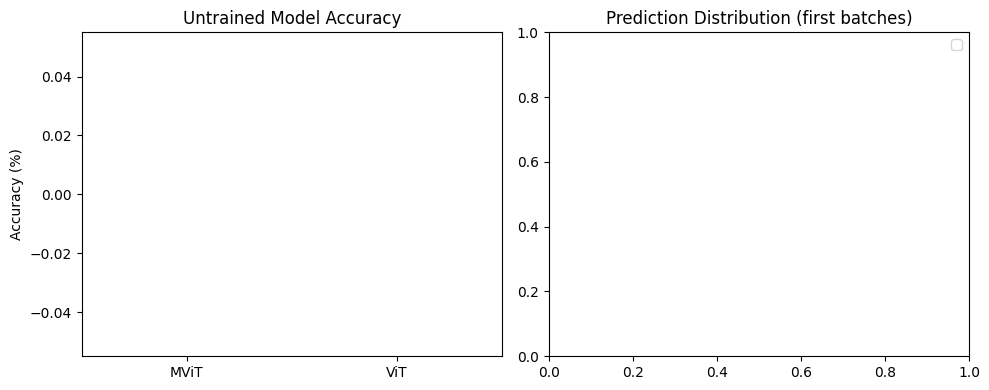

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.barplot(x=["MViT", "ViT"], y=[mvit_acc, vit_acc], ax=axes[0])
axes[0].set_title("Untrained Model Accuracy")
axes[0].set_ylabel("Accuracy (%)")

sns.histplot(mvit_preds, color="blue", label="MViT", kde=False, ax=axes[1])
sns.histplot(vit_preds, color="orange", label="ViT", kde=False, ax=axes[1])
axes[1].set_title("Prediction Distribution (first batches)")
axes[1].legend()

plt.tight_layout()
plt.show()
